# Searchflow

### Packages needed to run this notebook
- libmagic: ```brew install libmagic```


### ChromaDB
Don't forget to start the ChromaDB server: ```docker run -p 8000:8000 chromadb/chroma```

In [2]:
# Load packages from the src directory
import sys
sys.path.append('../src')

from dotenv import load_dotenv
load_dotenv()

from searchflow import ExtractDocuments, setup_logger, ExtractMetaData

### Extracting chunks of data from a document

In [3]:
# Extract chunks of data from a document
extract = ExtractDocuments(
    logger=setup_logger(name="Files", level="INFO"),
    )

result = extract.extract(file_path="files/attention_is_all_you_need.pdf", )

# Add additional metadata using a NER-pipeline
ner = ExtractMetaData(
    logger=setup_logger(name="ExtractMetaData", level="INFO",),
    model="llama3.1" # Both llama3.1 or gpt-4o-mini are supported in this demo
    )
result_with_metadata = ner.extract(result, source="uploaded_file")


2024-10-22 18:07:26,553 - Files - INFO - Extracting documents from files/attention_is_all_you_need.pdf
2024-10-22 18:07:31,807 - ExtractMetaData - INFO - Extracting metadata from 52 documents, using llama3.1


### Adding the documents to a vector database (Chroma)

For this demo, the vector database will be saved locally on disk, restarting the container will delete the database.
I prefer using the cosine distance instead of the default squared L2 distance, we pass this using the `hnsw:space` metadata.

$$
d = 1.0 - \frac{\sum(A_i \times B_i)}{\sqrt{\sum(A_i^2) \cdot \sum(B_i^2)}}
$$

We use Ollama to calculate the embeddings locally with BGE-M3, since over a 100 langues are supported this is ideal for embedding Arabic documents.

BGE-M3 is based on the XLM-RoBERTa architecture and is distinguished for its versatility in Multi-Functionality, Multi-Linguality, and Multi-Granularity:

- Multi-Functionality: It can simultaneously perform the three common retrieval functionalities of embedding model: dense retrieval, multi-vector retrieval, and sparse retrieval.
- Multi-Linguality: It can support more than 100 working languages.
- Multi-Granularity: It is able to process inputs of different granularities, spanning from short sentences to long documents of up to 8192 tokens.

> ℹ️ So all embeddings will be calculated locally ℹ️


In [4]:
from searchflow import VectorDB
import pathlib
import os

vector_db = VectorDB(logger=setup_logger(name="VectorDB", level="INFO"))

2024-10-22 18:11:10,523 - VectorDB - WARNING - Demo collection already exists


In [5]:
vector_db.add_documents(result_with_metadata)

In [6]:
# Now let's query the vector database
vector_db.similarity_search(
    query="Explain how decoder architecture is used in the paper?",
    k=3
    )

[Document(metadata={'author': '', 'content_type': 'blog_post', 'filename': 'attention_is_all_you_need.pdf', 'filetype': 'application/pdf', 'language': 'EN', 'last_modified': '2024-10-21T15:29:32', 'read_time': 0.59, 'source': 'uploaded_file', 'summary': 'Most competitive neural sequence transduction models have an encoder-decoder structure.', 'tags': "['AI', 'Model Architecture']", 'word_count': 118, 'cosine_distance': 0.3770288509348262}, page_content='3 Model Architecture\n\nMost competitive neural sequence transduction models have an encoder-decoder structure [5, 2, 35]. Here, the encoder maps an input sequence of symbol representations (x1, ..., xn) to a sequence of continuous representations z = (z1, ..., zn). Given z, the decoder then generates an output sequence (y1, ..., ym) of symbols one element at a time. At each step the model is auto-regressive [10], consuming the previously generated symbols as additional input when generating the next.\n\n2\n\nFigure 1: The Transformer -

### Ask questions using LangGraph
 Let's now ask questions using the LangGraph workflow

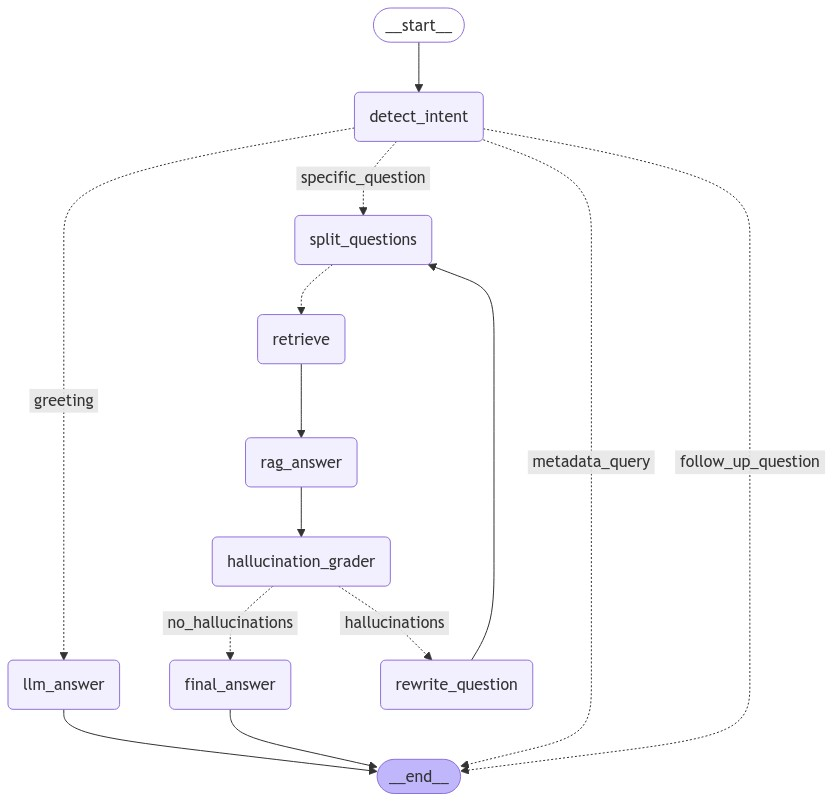

The decoder architecture in the paper is composed of a stack of six identical layers. Each layer in the decoder has three sub-layers. The first two sub-layers are similar to those in the encoder: a multi-head self-attention mechanism and a position-wise fully connected feed-forward network. The third sub-layer in the decoder performs multi-head attention over the output of the encoder stack. 

Additionally, the decoder employs residual connections around each of the sub-layers, followed by layer normalization. A key modification in the decoder's self-attention sub-layer is the use of masking to prevent positions from attending to subsequent positions. This ensures that the prediction for a position can only depend on the known outputs at positions before it. The output embeddings are also offset by one position to maintain this dependency structure.

{'id': '33ec71d0-d1f3-402d-b57a-b40e335b8b9f', 'object': 'chat.completion.chunk', 'created': 1729613510, 'model': 'SearchFlow Custom Grap

In [7]:
from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from searchflow import default_graph
from searchflow.graphs.utils.stream_processor import StreamProcessor
import warnings

# Display the graph
display(Image(default_graph.get_graph().draw_mermaid_png()))

stream = StreamProcessor(graph=default_graph, logger=setup_logger(name="StreamProcessor", level="INFO"))

# Set the input message
input = [HumanMessage(content="Explain how decoder architecture is used in the paper?")]

# Run the stream and print the chunks
async for chunk in stream.process_stream(messages=input):
    print(chunk)